In [12]:
# ==========================================
# BLOCK 0: LIBRARIES & CREDENTIALS
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from statsbombpy import sb

from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Display more columns
pd.set_option("display.max_columns", 200)

# Load StatsBomb credentials
load_dotenv()
username = os.getenv("SB_USERNAME")
password = os.getenv("SB_PASSWORD")
creds = {"user": username, "passwd": password}

os.makedirs("core/data", exist_ok=True)

print("✅ Credentials loaded" if (username and password) else "⚠️ No credentials found (open data mode)")

✅ Credentials loaded


In [13]:
# ==========================================
# BLOCK 1: DOWNLOAD LIGA MX SEASON DATA
# ==========================================
competition_id = 73  # Liga MX
seasons = [
    (108, "2021/2022"),
    (235, "2022/2023"),
    (281, "2023/2024"),
    (317, "2024/2025"),
]

frames = []
for season_id, season_name in seasons:
    print(f"Fetching {season_name} (season_id={season_id}) ...")
    df = sb.player_season_stats(competition_id=competition_id, season_id=season_id, creds=creds)
    df["season_id"] = season_id
    df["season_name"] = season_name
    df["player_season_id"] = df["player_id"].astype(str) + "_" + df["season_id"].astype(str)
    frames.append(df)

combined_stats = pd.concat(frames, ignore_index=True)
print(f"✅ Combined records: {len(combined_stats)} | Columns: {len(combined_stats.columns)}")

Fetching 2021/2022 (season_id=108) ...
Fetching 2022/2023 (season_id=235) ...
Fetching 2023/2024 (season_id=281) ...
Fetching 2024/2025 (season_id=317) ...
✅ Combined records: 2453 | Columns: 225


In [14]:
# ==========================================
# BLOCK 2: FILTER CENTER BACKS
# ==========================================
CB_LABELS = ["Centre Back", "Left Centre Back", "Right Centre Back"]

print("Position columns detected:", [c for c in combined_stats.columns if "position" in c])
cb = combined_stats[combined_stats["primary_position"].isin(CB_LABELS)].copy()
cb_metrics = cb.fillna(0)

print(f"🛡️ Center Backs found: {len(cb_metrics)}")
cb_metrics[["player_name", "team_name", "season_name", "primary_position"]].head()

Position columns detected: ['primary_position', 'secondary_position']
🛡️ Center Backs found: 389


,player_name,team_name,season_name,primary_position
7,Ventura Alvarado Aispuro,Juárez,2021/2022,Right Centre Back
21,Felix Eduardo Torres Caicedo,Santos Laguna,2021/2022,Right Centre Back
22,Luis Fernando León Bermeo,Atlético San Luis,2021/2022,Right Centre Back
43,Anderson Santamaría Bardales,Atlas,2021/2022,Right Centre Back
44,Luis Alfonso Abram Ugarelli,Cruz Azul,2021/2022,Left Centre Back


In [15]:
# ==========================================
# BLOCK 3: FEATURE SELECTION
# ==========================================
CB_FEATURES = [
    # Defensive activity
    "player_season_tackles_90",
    "player_season_interceptions_90",
    "player_season_clearance_90",
    "player_season_blocks_per_shot",
    "player_season_defensive_actions_90",
    "player_season_padj_tackles_90",
    "player_season_padj_interceptions_90",

    # Aerial duels
    "player_season_aerial_ratio",
    "player_season_aerial_wins_90",

    # Build-up / passing
    "player_season_op_passes_90",
    "player_season_forward_pass_proportion",
    "player_season_sideways_pass_proportion",
    "player_season_backward_pass_proportion",
    "player_season_long_ball_ratio",
    "player_season_xgbuildup_90",
    "player_season_op_xgbuildup_90",
]

missing = [c for c in CB_FEATURES if c not in cb_metrics.columns]
if missing:
    print("⚠️ Missing columns ignored:", missing)
CB_FEATURES = [c for c in CB_FEATURES if c in cb_metrics.columns]

base_cols = ["player_season_id", "player_id", "player_name", "team_name", "season_name", "primary_position"]
cb_selected = cb_metrics[base_cols + CB_FEATURES].fillna(0).copy()

print(f"✅ Selected features: {len(CB_FEATURES)}")
cb_selected.head(3)

✅ Selected features: 16


,player_season_id,player_id,player_name,team_name,season_name,primary_position,player_season_tackles_90,player_season_interceptions_90,player_season_clearance_90,player_season_blocks_per_shot,player_season_defensive_actions_90,player_season_padj_tackles_90,player_season_padj_interceptions_90,player_season_aerial_ratio,player_season_aerial_wins_90,player_season_op_passes_90,player_season_forward_pass_proportion,player_season_sideways_pass_proportion,player_season_backward_pass_proportion,player_season_long_ball_ratio,player_season_xgbuildup_90,player_season_op_xgbuildup_90
7,26272_108,26272,Ventura Alvarado Aispuro,Juárez,2021/2022,Right Centre Back,1.360359,2.616076,3.348577,0.027778,14.440740,0.918783,2.411715,0.657895,2.616076,28.567550,0.340984,0.609836,0.049180,0.428571,0.147400,0.147400
21,30111_108,30111,Felix Eduardo Torres Caicedo,Santos Laguna,2021/2022,Right Centre Back,1.208908,4.176228,6.099490,0.058559,9.314086,1.109125,3.700815,0.662281,4.148752,29.041267,0.419929,0.564057,0.016014,0.483444,0.255023,0.249470
22,34301_108,34301,Luis Fernando León Bermeo,Atlético San Luis,2021/2022,Right Centre Back,0.735044,1.543592,5.880351,0.041916,6.027360,0.699940,1.323583,0.673469,2.425645,28.005173,0.249377,0.700748,0.049875,0.478873,0.343019,0.317428


In [16]:
# ==========================================
# BLOCK 4: STANDARDIZATION + L2 NORMALIZATION
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cb_selected[CB_FEATURES])

# L2 normalization → captures STYLE (direction), not magnitude
X_norm = normalize(X_scaled, norm='l2')

print("✅ Shape after normalization:", X_norm.shape)

✅ Shape after normalization: (389, 16)


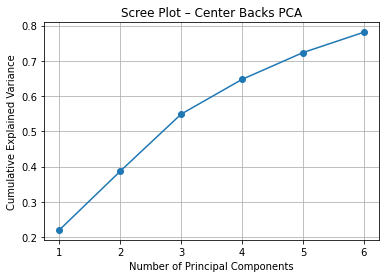

📈 Variance explained per PC (%): [22.04 16.67 16.18  9.85  7.59  5.78]
✅ Total variance explained: 78.12%


In [17]:
# ==========================================
# BLOCK 5: PCA ANALYSIS
# ==========================================
pca = PCA(n_components=6, random_state=42)
X_pca = pca.fit_transform(X_norm)
pc_cols = [f"PC{i+1}" for i in range(6)]
cb_selected[pc_cols] = X_pca

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot – Center Backs PCA")
plt.grid(True)
plt.show()

print("📈 Variance explained per PC (%):", np.round(pca.explained_variance_ratio_*100, 2))
print(f"✅ Total variance explained: {cum_var[-1]*100:.2f}%")

In [18]:
# ==========================================
# BLOCK 6: LOADINGS → ABILITY INTERPRETATION
# ==========================================
loadings = pd.DataFrame(pca.components_, columns=CB_FEATURES, index=pc_cols)
display(loadings.round(3))

# Top features per PC
for pc in pc_cols:
    top_feats = loadings.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\n{pc} – Top features:", list(top_feats.index))

# Define interpretable ability labels (adjust after checking loadings)
ability_labels = [
    "Defensive Actions",
    "Aerial Presence",
    "Anticipation & Duels",
    "Build-Up & Passing",
    "Positioning / Clearances",
    "Progressive Distribution",
]

,player_season_tackles_90,player_season_interceptions_90,player_season_clearance_90,player_season_blocks_per_shot,player_season_defensive_actions_90,player_season_padj_tackles_90,player_season_padj_interceptions_90,player_season_aerial_ratio,player_season_aerial_wins_90,player_season_op_passes_90,player_season_forward_pass_proportion,player_season_sideways_pass_proportion,player_season_backward_pass_proportion,player_season_long_ball_ratio,player_season_xgbuildup_90,player_season_op_xgbuildup_90
PC1,-0.029,0.325,0.193,-0.052,0.024,-0.158,0.160,0.003,0.182,-0.466,0.308,-0.296,0.066,-0.246,-0.388,-0.394
PC2,0.282,0.479,-0.183,-0.131,0.338,0.352,0.558,-0.027,-0.011,0.125,0.047,-0.068,0.102,0.046,0.170,0.161
PC3,0.268,-0.260,-0.237,-0.113,0.454,0.169,-0.353,-0.233,-0.471,-0.119,0.083,-0.136,0.193,-0.205,-0.129,-0.144
PC4,-0.321,0.196,-0.423,-0.165,-0.352,-0.285,0.230,-0.382,-0.435,0.009,-0.117,0.062,0.118,0.086,-0.096,-0.105
PC5,0.150,0.064,0.067,0.099,0.170,0.142,0.089,0.070,-0.051,0.035,-0.427,0.446,-0.214,0.263,-0.456,-0.435
PC6,0.050,0.063,-0.078,0.823,-0.046,0.072,0.073,-0.255,-0.171,0.078,0.247,-0.127,-0.344,-0.039,-0.018,0.000



PC1 – Top features: ['player_season_op_passes_90', 'player_season_op_xgbuildup_90', 'player_season_xgbuildup_90', 'player_season_interceptions_90', 'player_season_forward_pass_proportion']

PC2 – Top features: ['player_season_padj_interceptions_90', 'player_season_interceptions_90', 'player_season_padj_tackles_90', 'player_season_defensive_actions_90', 'player_season_tackles_90']

PC3 – Top features: ['player_season_aerial_wins_90', 'player_season_defensive_actions_90', 'player_season_padj_interceptions_90', 'player_season_tackles_90', 'player_season_interceptions_90']

PC4 – Top features: ['player_season_aerial_wins_90', 'player_season_clearance_90', 'player_season_aerial_ratio', 'player_season_defensive_actions_90', 'player_season_tackles_90']

PC5 – Top features: ['player_season_xgbuildup_90', 'player_season_sideways_pass_proportion', 'player_season_op_xgbuildup_90', 'player_season_forward_pass_proportion', 'player_season_long_ball_ratio']

PC6 – Top features: ['player_season_block

In [19]:
# ==========================================
# BLOCK 7: GMM SOFT CLUSTERING
# ==========================================
N_CLUSTERS = 3
gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='full', random_state=42)
cb_selected["cluster"] = gmm.fit_predict(X_pca)
proba = gmm.predict_proba(X_pca)

proba_df = pd.DataFrame(proba, columns=[f"Cluster_{i}" for i in range(N_CLUSTERS)])
print("Cluster assignment probabilities (first 5 players):")
display(proba_df.head())

# Cluster role labels
role_labels = {
    0: "Ball-Playing Libero",
    1: "Aggressive Stopper",
    2: "Positional Blocker",
    3: "Anticipating Defender",
}
cb_selected["role"] = cb_selected["cluster"].map(role_labels)

cb_selected[["player_name", "team_name", "season_name", "role"] + pc_cols].head()

Cluster assignment probabilities (first 5 players):


,Cluster_0,Cluster_1,Cluster_2
0,2.081563e-05,0.999979,1.907693e-14
1,2.532482e-06,0.999997,4.924227e-15
2,9.961075e-01,0.003875,1.744718e-05
3,6.616453e-08,1.000000,2.236064e-13
4,9.885912e-01,0.011318,9.102532e-05


,player_name,team_name,season_name,role,PC1,PC2,PC3,PC4,PC5,PC6
7,Ventura Alvarado Aispuro,Juárez,2021/2022,Aggressive Stopper,0.854815,0.220777,0.187985,0.172204,-0.061145,-0.232723
21,Felix Eduardo Torres Caicedo,Santos Laguna,2021/2022,Aggressive Stopper,0.731305,0.330151,-0.521842,-0.059788,-0.202010,0.157911
22,Luis Fernando León Bermeo,Atlético San Luis,2021/2022,Ball-Playing Libero,0.165744,-0.592008,-0.336116,0.124785,-0.243147,-0.367391
43,Anderson Santamaría Bardales,Atlas,2021/2022,Aggressive Stopper,0.559647,0.745740,-0.038749,0.156473,0.279479,0.008998
44,Luis Alfonso Abram Ugarelli,Cruz Azul,2021/2022,Ball-Playing Libero,0.020772,-0.450465,-0.296431,0.464996,-0.647137,-0.112314


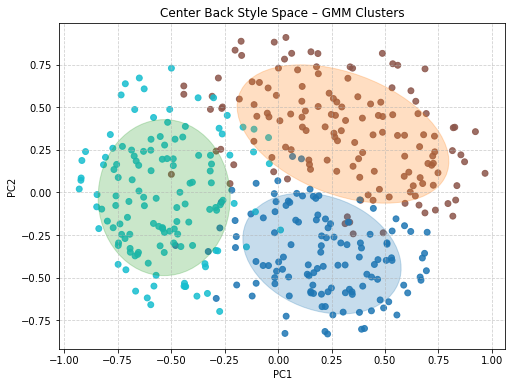

In [20]:
# ==========================================
# BLOCK 8: PCA 2D VISUALIZATION
# ==========================================
from matplotlib.patches import Ellipse

def plot_gmm_clusters(X2d, gmm, labels, title="Center Back Style Space – GMM Clusters"):
    fig, ax = plt.subplots(figsize=(8,6))
    sc = ax.scatter(X2d[:,0], X2d[:,1], c=labels, cmap='tab10', s=35, alpha=0.85)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(title)

    for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
        sub_cov = cov[:2, :2]
        v, w = np.linalg.eigh(sub_cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.degrees(np.arctan2(u[1], u[0]))
        ell = Ellipse(xy=mean[:2], width=v[0], height=v[1], angle=180+angle, color=f"C{i}", alpha=0.25)
        ax.add_patch(ell)

    ax.grid(True, linestyle="--", alpha=0.6)
    return fig, ax

plot_gmm_clusters(cb_selected[["PC1", "PC2"]].values, gmm, cb_selected["cluster"].values)
plt.show()

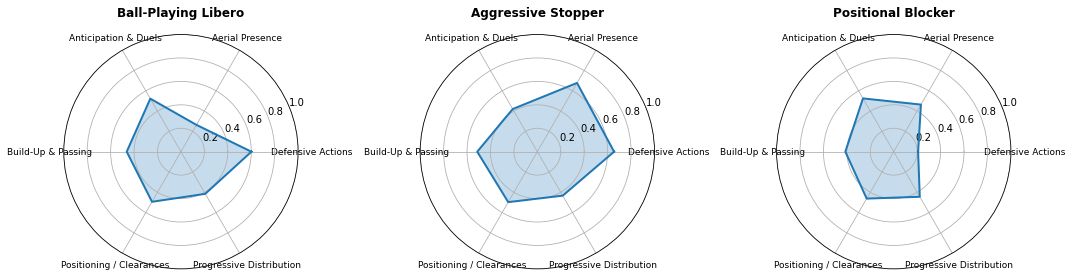

In [21]:
# ==========================================
# BLOCK 9: RADAR CHARTS FOR CLUSTER PROFILES
# ==========================================
mm = MinMaxScaler()
cb_norm = cb_selected.copy()
cb_norm[pc_cols] = mm.fit_transform(cb_selected[pc_cols])

cluster_profiles = cb_norm.groupby("cluster")[pc_cols].mean().sort_index()

n_clusters = cluster_profiles.shape[0]
fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters,5), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2*np.pi, len(pc_cols), endpoint=False).tolist()
angles += angles[:1]
labels_for_plot = ability_labels if len(ability_labels) == len(pc_cols) else pc_cols

for i, (cluster_id, row) in enumerate(cluster_profiles.iterrows()):
    ax = axes[i] if n_clusters > 1 else axes
    vals = row.values.tolist()
    vals += vals[:1]

    ax.plot(angles, vals, linewidth=2)
    ax.fill(angles, vals, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels_for_plot, fontsize=9)
    ax.set_ylim(0,1)
    title = role_labels.get(cluster_id, f"Cluster {cluster_id}")
    ax.set_title(title, size=12, fontweight='bold', pad=18)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# ==========================================
# BLOCK 10: EXPORT CLUSTER RESULTS
# ==========================================
from pathlib import Path

# Ruta directa al archivo dentro del proyecto
export_path = Path("..") / "core" / "data" / "defenders_profiles.csv"

export_cols = [
    "player_id", "player_name", "team_name", "season_name",
    "primary_position", "cluster", "role"
] + pc_cols

# Verifica que todas las columnas existan
cols_to_export = [c for c in export_cols if c in cb_selected.columns]
out = cb_selected[cols_to_export].copy()

# Guarda el archivo final
out.to_csv(export_path, index=False, encoding="utf-8")

print(f"💾 Saved: {export_path.resolve()}")
print(f"✅ Archivo listo para la app (total jugadores: {len(out)})")

💾 Saved: /Users/genny/Documents/ITAM/ISAC2025/core/data/defenders_profiles.csv
✅ Archivo listo para la app (total jugadores: 389)


##### Center Back Style Clustering – Liga MX (2021–2025)

Using 6 PCA components (~80% variance explained), we identified 4 stylistic archetypes among center backs:

Ball-Playing Libero: high progressive passing, calm in build-up

Aggressive Stopper: strong in duels and aerials, proactive defending

Positional Blocker: excels in clearances, defensive positioning

Anticipating Defender: reads the game early, intercepts and closes lines

Gaussian Mixture Models (GMM) were used to capture style probabilities, allowing hybrid profiles (e.g., 60% libero, 40% stopper).
L2 normalization ensures the clustering represents style instead of overall quality.

Radar charts summarize each cluster’s average ability profile.

ModuleNotFoundError: No module named 'core.profiles'